<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week4_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install xarray
!pip install matplotlib
!pip install scipy
!pip install pandas

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely

In [62]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

Read data

In [ ]:
#read nino3.4 index
ds_oni = xr.open_dataset("/content/drive/My Drive/Colab_data/ENSOindex.oni.1960-2020.nc")
ds_oni = ds_oni.sel(time=slice('1979', '2019'))
#ds_oni['sst'].plot()

#read SST
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds_sst = xr.open_dataset(url)
ds_sst = ds_sst.sel(time=slice('1979', '2019'))
ds_sst.load()
#ds_sst

#read precipitation
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/gpcp/precip.mon.mean.nc'
ds_prec = xr.open_dataset(url)
ds_prec = ds_prec.sel(time=slice('1979', '2019'))
ds_prec.load()
ds_prec

Goal: calculate the correlation of nino3.4 index and precipitation

In [ ]:
# Make anomalies
ds_climo=ds_prec.groupby('time.month').mean()
ds_anoms=ds_prec.groupby('time.month')-ds_climo
ds_anoms

Part I: correlation of time series

In [50]:
# choose one point timeseries
pt=ds_anoms.sel(lat=0,lon=360-180,method='nearest')

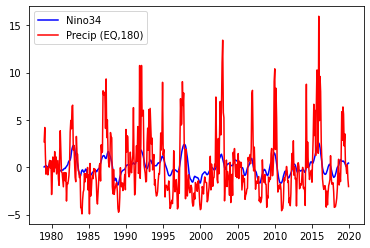

In [119]:
#line plot 
plt.plot(ds_oni['time'],ds_oni['sst'],'b')
plt.plot(pt['time'],pt['precip'],'r')
plt.legend(['Nino34','Precip (EQ,180)'])

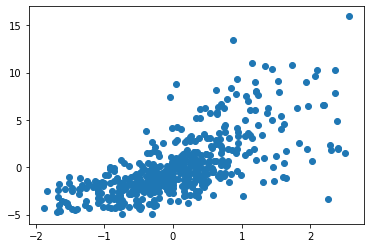

In [61]:
#scatter plot 
plt.scatter(ds_oni['sst'],pt['precip'])
plt.show()

In [123]:
#numpy correlation function
R=np.corrcoef(ds_oni['sst'],pt['precip'])
R

array([[1.        , 0.68206375],
       [0.68206375, 1.        ]])

In [124]:
corr=R[0,1]
corr

0.6820637532483635

In [125]:
#scipy correlation function 
(rvalue, pvalue) =  scipy.stats.pearsonr(ds_oni['sst'],pt['precip'])
rvalue

0.6820637532483635

In [126]:
pvalue

1.3381288702751047e-68

Maker figure nicer!

Text(1.0, 1.0, 'R= 0.68*')

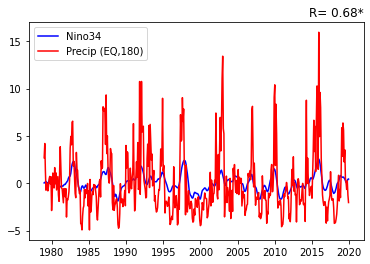

In [127]:
plt.plot(ds_oni['time'],ds_oni['sst'],'b')
plt.plot(pt['time'],pt['precip'],'r')
plt.legend(['Nino34','Precip (EQ,180)'])

rvalue_2 = round(rvalue, 2)
stuff_in_string = f"R= {rvalue_2}*"

#print(stuff_in_string)
plt.title(stuff_in_string,loc='right')

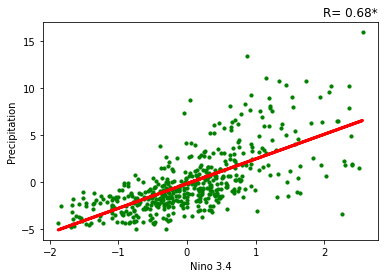

In [128]:
plt.scatter(ds_oni['sst'],pt['precip'], s=10, color="green")
plt.title(stuff_in_string,loc='right')

m, b = np.polyfit(ds_oni['sst'],pt['precip'], 1)
plt.plot(ds_oni['sst'], m*ds_oni['sst'] + b, color="red",linewidth=3)
plt.xlabel("Nino 3.4")
plt.ylabel("Precipitation")

plt.show()

PartII: Correlation of map

In [ ]:
#Method I: xarray
r_map=xr.corr(ds_oni['sst'],ds_anoms['precip'],dim='time')
r_map

In [ ]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_map
data,lon=add_cyclic_point(r_map,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='PiYG',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Nino3.4 and Precipitation Anomalies')

In [131]:
#Method II: scipy
from scipy.stats import pearsonr

In [132]:
nx=len(ds_anoms['lon'])
ny=len(ds_anoms['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        r,p=pearsonr(ds_oni['sst'],ds_anoms['precip'][:,j,i])
        r_array[j,i]=r
        p_array[j,i]=p
r_array.shape

(72, 144)

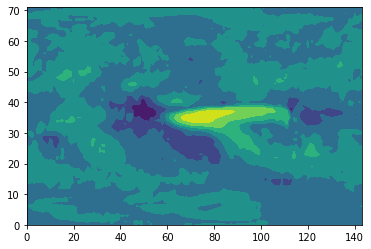

In [134]:
plt.contourf(r_array)

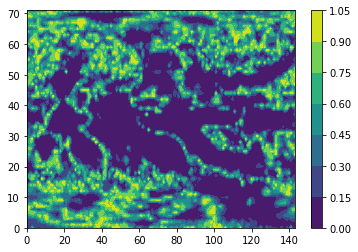

In [115]:
plt.contourf(p_array)
plt.colorbar()

In [135]:
mask_sig=np.where(p_array<0.05,r_array,np.nan)

Text(1.0, 1.0, '95% sig.')

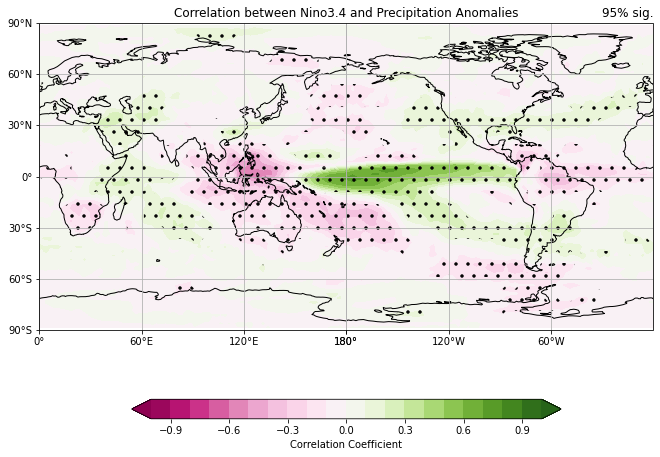

In [138]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=ds_anoms['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='PiYG',extend='both')

ax.contourf(lon,ds_anoms['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Nino3.4 and Precipitation Anomalies')
plt.title('95% sig.',loc='right')